## Exercises

## 1. Given the following dataframe of sales transactions

In [2]:
import pandas as pd
import numpy as np

In [6]:
data = {
    "date": [
        "2023-05-01", "2023-05-02",
        "2023-05-05", "2023-05-07",
        "2023-05-10", "2023-05-15",
        "2023-05-20", "2023-05-25",
        "2023-05-30", "2023-05-31"
    ],
    "sales_amount": [100, 150, 200, 130, 180, 250, 300, 220, 270, 310]
}

df = pd.DataFrame(data)

In [7]:
df

date  sales_amount
0  2023-05-01           100
1  2023-05-02           150
2  2023-05-05           200
3  2023-05-07           130
4  2023-05-10           180
5  2023-05-15           250
6  2023-05-20           300
7  2023-05-25           220
8  2023-05-30           270
9  2023-05-31           310

- create a new column with the number of days since the last sales

In [8]:
df['date'] = pd.to_datetime(df['date'])

In [136]:
df['days_since_the_last_sale'] = df['date'].diff().dt.days.fillna(0).astype(int)

#df
*.diff* --> trova la differenza tra una data e la data precedente.......
*.dt.days* --> come scansione del tempo prendo i giorni.......
*.fillna(0)* --> per rimuovere il Nan dalla prima riga........
*.astype(int)* --> differenza tra giorni sono numeri interi......

- add missing dates, filling missing values for sales_amount with 0

In [138]:
all_month = pd.date_range(start=df['date'].min(), end=df['date'].max())

oppure con df=df.asfreq('D', fill_value=0)

In [139]:
df = df.set_index('date').reindex(all_month, fill_value=0).reset_index()

In [16]:
#rename the column index in "date"
df.rename(columns={'index': 'date'}, inplace=True)
#df

- create a new column with the sale amount of 7 days before

In [141]:
df['sales_7_days_ago'] = df['sales_amount'].shift(7).fillna(0)
#df

- create a new column with the mean amount of sales for the previous 7 days

In [142]:
df['mean_sales_last_7_days'] = df['sales_amount'].rolling(7).mean().shift(1).fillna(0)

*rolling* genera una finestra mobile su cui si mediano i dati ( *.mean()*  )

- convert the frequency to weekly, summing the sales for each week

In [110]:
weekly_sales= df.set_index('date').resample('W')['sales_amount'].sum().reset_index()
weekly_sales['week_start']= weekly_sales['date'] - pd.Timedelta(days=6)
weekly_sales['week_end']= weekly_sales['date']
weekly_sales = weekly_sales[['week_start', 'week_end', 'sales_amount']]
weekly_sales

week_start   week_end  sales_amount
0 2023-05-01 2023-05-07           580
1 2023-05-08 2023-05-14           180
2 2023-05-15 2023-05-21           550
3 2023-05-22 2023-05-28           220
4 2023-05-29 2023-06-04           580

sommo i dati della settimana precedenti ad ogni domenica _ W vado di default su domenica

## 2. Given the following sales data

In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.holtwinters import SimpleExpSmoothing, ExponentialSmoothing
from statsmodels.tsa.seasonal import STL

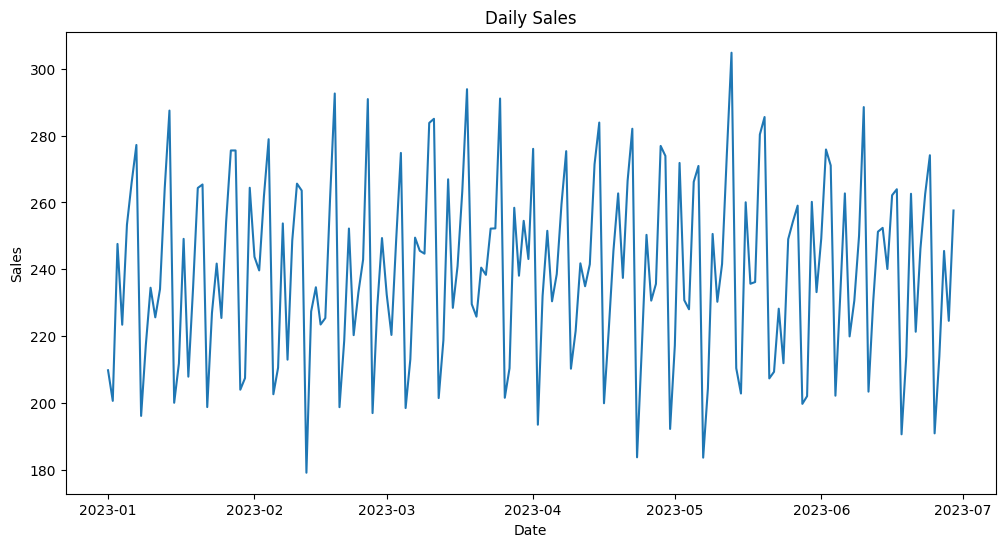

In [19]:
date_range = pd.date_range(start="2023-01-01", periods=180, freq="D")
values = np.array([200, 220, 250, 230, 240, 260, 280], dtype=float)
sales = np.tile(values, len(date_range) // 7 + 1)[:len(date_range)]
sales += np.random.normal(0, 10, len(sales))

df = pd.DataFrame({"date": date_range, "sales": sales})
df.set_index("date", inplace=True)

#figure
plt.figure(figsize=(12, 6))
sns.lineplot(data=df, x=df.index, y="sales")
plt.title("Daily Sales")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.show()

In [30]:
stl = STL(df['sales'], period=7)  
decomposition = stl.fit()
# period=7 indica la stagionalità settimanale

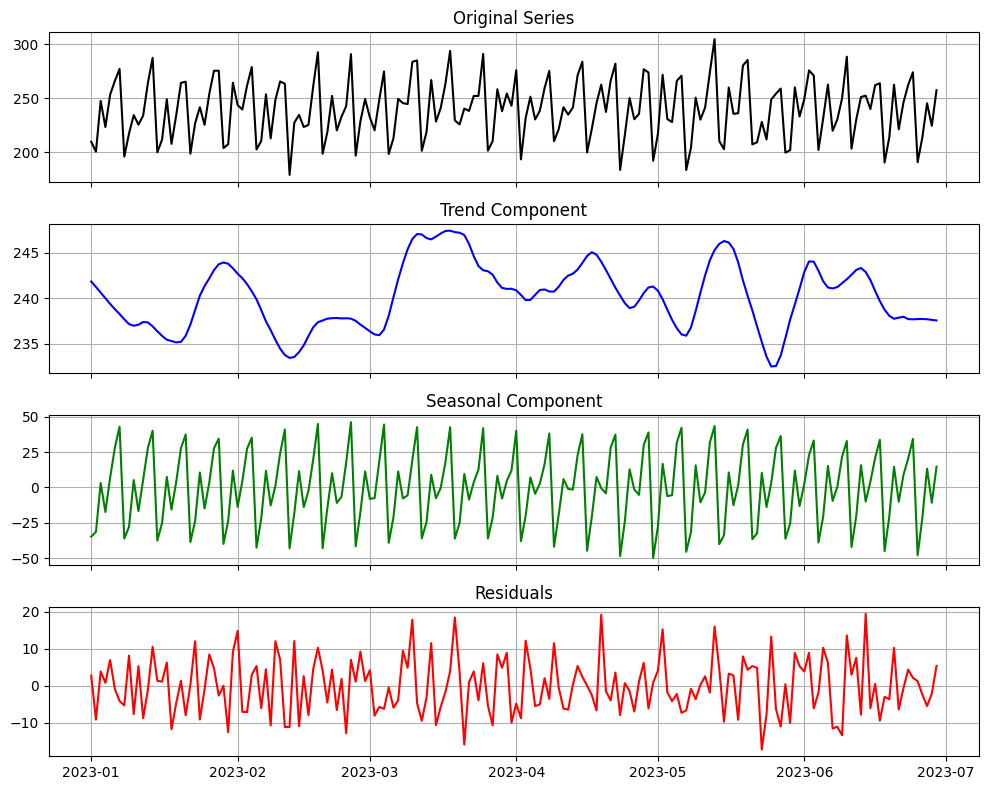

In [31]:
fig, axes = plt.subplots(4, 1, figsize=(10, 8), sharex=True)
axes[0].plot(df.index, df['sales'], label='Original Series',color="k")
axes[0].set_title('Original Series')
axes[0].grid()

# Trend
axes[1].plot(df.index, decomposition.trend, label='Trend',color="blue")
axes[1].set_title('Trend Component')
axes[1].grid()

# Seasonal
axes[2].plot(df.index, decomposition.seasonal, label='Seasonal Component',color="g")
axes[2].set_title('Seasonal Component')
axes[2].grid()

# Residuals
axes[3].plot(df.index, decomposition.resid, label='Residuals',color="red")
axes[3].set_title('Residuals')
axes[3].grid()

plt.tight_layout()
plt.show()

- Use the appropriate Exponential Smoothing model to forecast sales for the following 7 days.

(imposto la frequenza in #day  altrimenti da un avviso, ma mette in automatico freq day)

In [32]:
df.index.freq = 'D'

In [33]:
# Exponential Smoothing
holtwinters_model = ExponentialSmoothing(df['sales'], trend='add', seasonal='add', seasonal_periods=7).fit()

Per serie temorali con trend non lineare e stagionalità settimanale: Exponential Smoothing - Holt  Winters

- previsione dei prossimi 7 giorni

In [34]:
holtwinters_forecast = holtwinters_model.forecast(7)

In [35]:
future_dates = pd.date_range(start=df.index[-1] + pd.Timedelta(days=1), periods=7, freq='D')
forecast_df = pd.DataFrame({"date": future_dates, "forecast": holtwinters_forecast})
forecast_df.set_index("date", inplace=True)
#forecast_df

- Bonus: plot the historical data and the generated forecast.

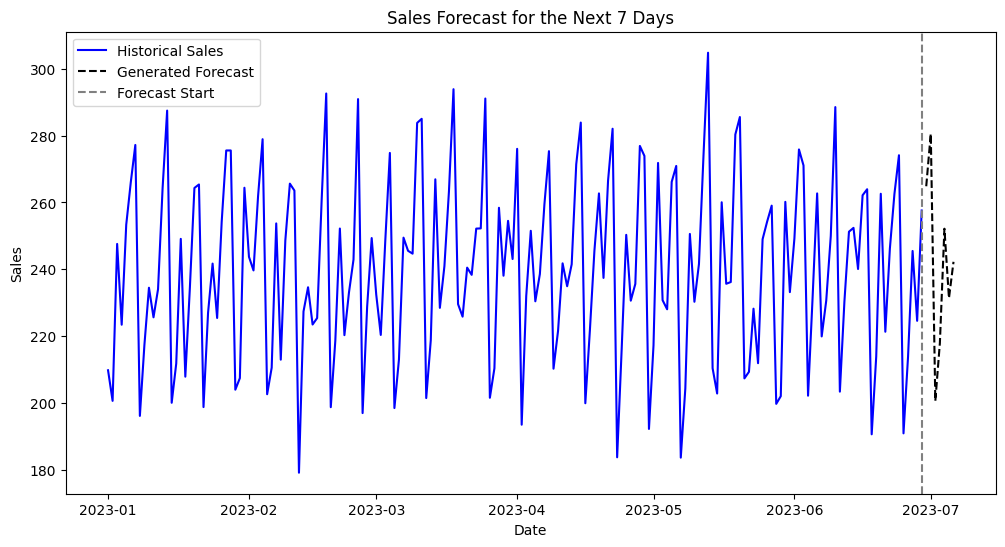

In [38]:
plt.figure(figsize=(12, 6))
sns.lineplot(data=df, x=df.index, y="sales", label="Historical Sales",color="b")
sns.lineplot(data=forecast_df, x=forecast_df.index, y="forecast", label="Generated Forecast", linestyle="--", color="k")
plt.axvline(df.index[-1], color="gray", linestyle="--", label="Forecast Start")
plt.title("Sales Forecast for the Next 7 Days")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.legend()
plt.show()